## ハイパーパラメータのチューニングライブラリのHypeOptを試す
- 参考
> https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt

### 必要なモジュールのimport

In [1]:
# !pip install hyperopt

In [2]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import multivariate_normal, binom

from functools import partial

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns

%matplotlib inline

from IPython.display import HTML

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# ================================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

from sklearn import datasets
from sklearn.utils import shuffle

### hyperoptを試す
- 2D平面上の簡単な例

関数とメッシュを作成

In [3]:
# ランダムのシードを指定
SEED = 21

# プロットする領域を指定
x_limits = (-10, 10)
y_limits = (-10, 10)

# --------------------------------

# 関数を定義
fct = lambda x, y: 5*np.exp(-((x - 3)**2 + (y - 4)**2)/4) + \
                   2*np.exp(-np.sqrt((x + 3)**2 + (y - 3)**2)/2) + \
                   1*np.exp(-np.sin(np.sqrt((x - 5)**2 + (y + 3)**2)/1))

# グリッド表示に必要な数値をリスト化
# x軸y軸の−１０から10
xy_mesh = np.meshgrid(np.linspace(*x_limits, 2001), np.linspace(*x_limits, 2001))
# 関数の最小値から最大値まで
fct_mesh = fct(xy_mesh[0], xy_mesh[1])

プロット
> 関数のグローバル最大値は(3, 4)付近にあり、ローカル最大値は(−3.5,3.5)付近にある。

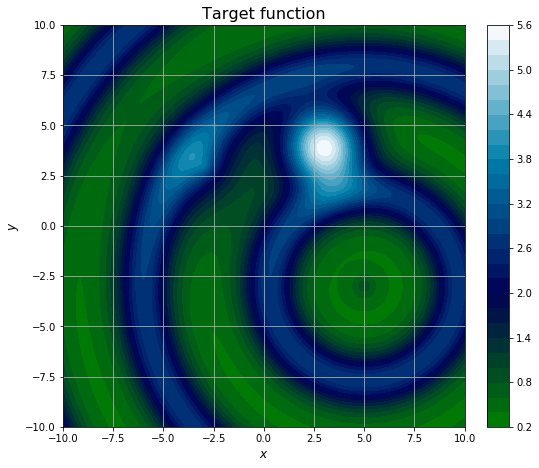

In [4]:
fig0 = plt.figure(figsize=(8, 8))

# 左側図の内容
cntr = plt.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
# 右側図の内容
_ = fig0.colorbar(cntr, ax=plt.gca(), fraction=0.05, pad=0.05, aspect=18)

plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Target function', fontsize=16)

plt.gca().grid(True)
plt.gca().set_aspect('equal')

Grid Search と Random Search

In [5]:
# 座標ごとのグリッド検索数
n_pts = 14

# グリッドサーチの構築
xy_GS = np.meshgrid(np.linspace(*x_limits, n_pts), np.linspace(*y_limits, n_pts))
# 評価する場所を指定
fct_GS = fct(xy_GS[0], xy_GS[1])

# グリッドサーチで得られた最良の点
best_GS = (fct_GS.max(), (xy_GS[0].flatten()[fct_GS.argmax()], 
                          xy_GS[1].flatten()[fct_GS.argmax()]))

# --------------------------------

# 乱数をシードにより固定
np.random.seed(SEED)

# 前図の良さそうな点を持ってくる
y_std = 5
# ランダムサーチの構築
xy_RS = [np.random.uniform(*x_limits, n_pts**2).reshape(n_pts, n_pts), 
         np.random.normal(0, y_std, n_pts**2).reshape(n_pts, n_pts)]
# 評価する場所を指定
fct_RS = fct(xy_RS[0], xy_RS[1])

# ランダムサーチで得られた最良の点
best_RS = (fct_RS.max(), (xy_RS[0].flatten()[fct_RS.argmax()], 
                          xy_RS[1].flatten()[fct_RS.argmax()]))

L-BFGS-B

In [6]:
# Initial guess and list of traversed points
xy_M = [(0.0, 0.0)]

# Function to dump current point in minimization algorithm to list
def f_current_point(x):
    xy_M.append(x)
    return None

# Starting maximization (minus sign since most optimization problems are 
# formulated in terms of finding minimum)
res_M = minimize(lambda x: -fct(*x), x0=xy_M[0], method='L-BFGS-B', 
                   bounds=[x_limits, y_limits], options={'maxiter': n_pts**2}, 
                   callback=f_current_point)

print(res_M)

# Best point obtained by L-BFGS-B
xy_M = np.array(xy_M).T
best_M = (-res_M.fun, res_M.x)

      fun: -5.540910223654586
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.24344979e-06, -1.48325796e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 11
   status: 0
  success: True
        x: array([3.01370178, 3.88382836])


hyperopt

In [7]:
# ハイパーパラメータの範囲を設定
hp_space = {'x': hp.uniform('x', *x_limits), 
            'y': hp.normal('y', 0, 5)}

# 評価数の設定
n_evals = n_pts**2
# 探索過程を記録するオブジェクト
trls = Trials()

# 最適化の実行
res_HO = fmin(lambda hps: -fct(hps['x'], hps['y']), space=hp_space, algo=tpe.suggest, 
                trials=trls, max_evals=n_evals, rstate=np.random.RandomState(SEED))

#　検索履歴を保存
xy_HO = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
         np.array([x['misc']['vals']['y'] for x in trls.trials])]
# hyperoptで得られた最良の点
best_HO = (-trls.best_trial['result']['loss'], (space_eval(hp_space, res_HO)['x'], 
                                                space_eval(hp_space, res_HO)['y']))

100%|██████████| 196/196 [00:00<00:00, 248.80it/s, best loss: -5.528460905856665]


結果の比較
- Grid Search: ハイパースペース全体に均一なメッシュがあり、結果がグローバル最大値に近い
- Random Search: かなり失敗している。ポイントの大部分が関数値の低い領域に集中している。
- L-BFGS-B: グローバル最大値を指し示すように手を加えているので、グローバル最大に収束
- Hyperopt: グローバル最大値付近の高いポイント密度を持ち、実際には、5.541に対する数値最大化-5.528とほぼ同じ性能を発揮

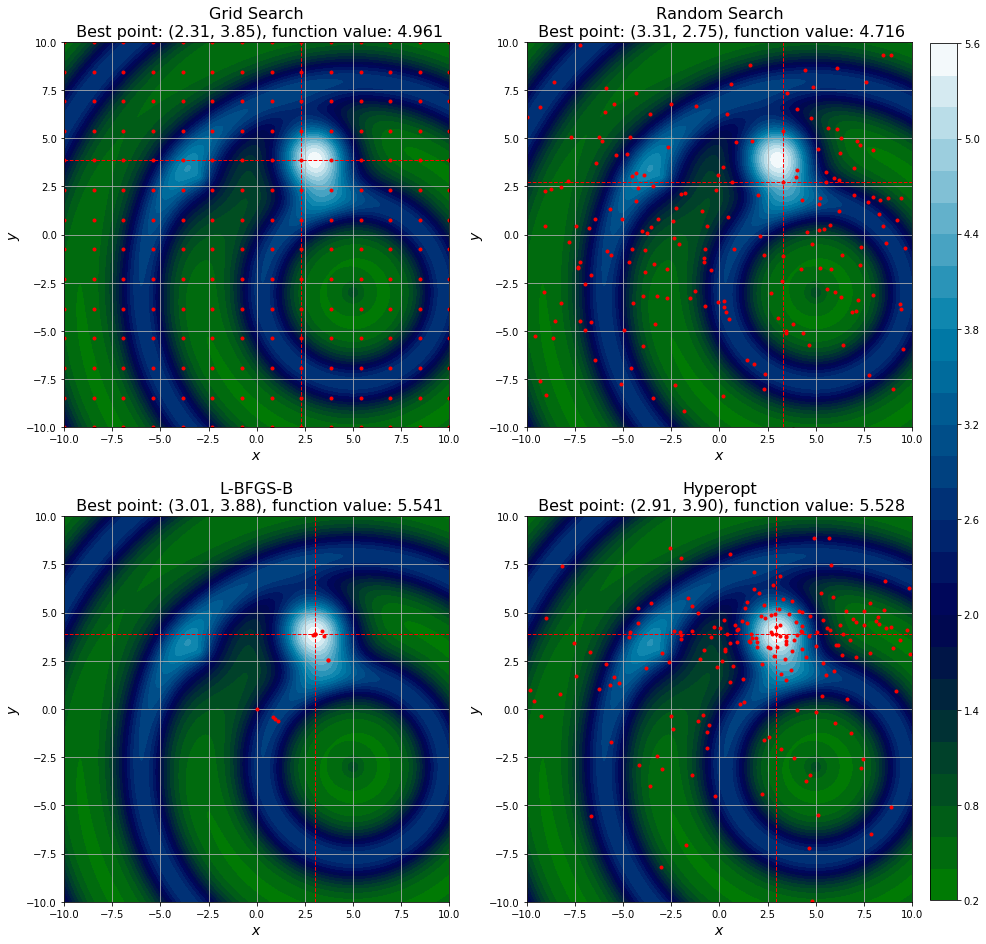

In [8]:
# Setting up layout and graph labels
fig0, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 16))
labels = ('Grid Search', 'Random Search', 'L-BFGS-B', 'Hyperopt')

# Plotting
for (xy, xlabel, xbest, ax) in zip((xy_GS, xy_RS, xy_M, xy_HO), 
                                   labels, 
                                   (best_GS, best_RS, best_M, best_HO), 
                                    axs.flatten()):
    # Function contour and points from search history
    cntr = ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    ax.plot(xy[0], xy[1], linewidth=0, marker='.', color='red')
    
    # Marking best result
    ax.plot(x_limits, [xbest[1][1]]*2, linewidth=1, linestyle='--', color='red')
    ax.plot([xbest[1][0]]*2, y_limits, linewidth=1, linestyle='--', color='red')
    
    # Formatting axes
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    ax.set_xlabel('$x$', fontsize = 14)
    ax.set_ylabel('$y$', fontsize = 14)
    
    ax.set_title('{0}\n Best point: ({1:.2f}, {2:.2f}), function value: {3:.3f}'.format(
        xlabel, *xbest[1], xbest[0]), fontsize=16)
    
    ax.grid(True)
    ax.set_aspect('equal')

# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=32)

Hyperoptを更に詳しく可視化する

In [9]:
# 探索過程を収集
steps = 2000

trls = Trials()
trls_random = Trials()

# ----------------

res_HO = fmin(lambda hps: -fct(hps['x'], hps['y']), space = hp_space, algo = tpe.suggest, 
              trials = trls, max_evals = steps, rstate = np.random.RandomState(SEED))

xy_HO2 = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls.trials])]


res_RS = fmin(lambda hps: -fct(hps['x'], hps['y']), space = hp_space, algo = tpe.rand.suggest, 
              trials = trls_random, max_evals = steps, rstate = np.random.RandomState(SEED))

xy_RS2 = [np.array([x['misc']['vals']['x'] for x in trls_random.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls_random.trials])]

100%|██████████| 2000/2000 [00:02<00:00, 733.53it/s, best loss: -5.509502038738186]


結果をアニメーション化

In [10]:
# Setting up figure
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
labels = ['Random Search', 'Hyperopt']

# Setting up animation frames
n_frames = 20
n_frame_pts = steps//n_frames

# Initial axes formatting
for (ax, xlabel) in zip(axs.flatten(), labels):
    ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    
    ax.set_xlim(x_limits)
    ax.set_xlim(y_limits)
    
    ax.set_title(xlabel, fontsize=16)
    
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14)

    ax.grid(True)
    ax.set_aspect('equal')
    
# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=15)

# Points and iteration indicator are the only things that change
pts0 = axs[0].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
pts1 = axs[1].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
fig0_tl = fig0.suptitle('Batch {0}'.format(0), fontsize=18)


def f_update_anim(frame, n_frames):
    """
    TODO
    """
    
    # Determine indexes of points within iteration
    idx0 = int(frame*len(trls)/n_frames)
    idx1 = int((frame + 1)*len(trls)/n_frames)
    
    # Plot new data
    pts0[0].set_data(xy_RS2[0][idx0:idx1], xy_RS2[1][idx0:idx1])
    pts1[0].set_data(xy_HO2[0][idx0:idx1], xy_HO2[1][idx0:idx1])
    fig0_tl.set_text('Batch {0}'.format(frame + 1, n_frames))
    
    return pts0[0], pts1[0], fig0_tl

plt.close()

# Set up animation
ani1 = FuncAnimation(fig0, lambda fr: f_update_anim(fr, n_frames), frames=n_frames, interval=500, blit=False)

HTML(ani1.to_jshtml())

### hyperoptを機械学習で使用する方法

必要なモジュールと例のインポート

In [11]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

各説明
- fmin: hyperoptの中心的関数、最良パラメータを説明付きで検索してくれる。
 - fn: 最小化したい目的関数（最大化が必要な関数の場合-をつけて指定する）
 - space: サンプリングする範囲
 - algo: 探索アルゴリズムの指定
 - max_evals: サンプリングする個数
 - trials: 最適化履歴を追跡するTrialクラスのオブジェクト
 - rstate: シードを固定する場合に使用
 - show_progressbar: 説明 
- hp: 変数の値域を定義するサブモジュール
- tpe: 誘導点サンプリングのためのアルゴリズムであり,Tree of Parzen Estimators
- Trials: 最適化プロセス全体を追跡するクラス、インスタンス(パラメータ値、損失値など。)
- space_eval(省略可能): 複雑なハイパースペースの場合に、ハイパースペースからパラメータ値を復元するのに役立つ
- scope(省略可能): パラメータの型変換に使用
- sample(省略可能): ハイパースペースからサンプルを抽出する関数。必須ではありませんが、fminを実行する前にハイパースペースを正しく記述したかどうかをテストするのに役立ちます。

探索スペースの定義方法
- hyperoptは、複雑な探索空間を設計できる。実数値のパラメータ、整数、ブール変数、さらには文字列を混在させることができ、それらに事前情報を確率分布の形で指定することもできる

In [12]:
# ロジスティック回帰用に正規化パラメータCの範囲を設定
hp_space = hp.uniform('C', low=0.01, high=100)
print(hp_space)
# Cは一様分布対数で設定した方が良いらしい
hp_space = hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))
print(hp_space)

0 float
1   hyperopt_param
2     Literal{C}
3     uniform
4      high =
5       Literal{100}
6      low =
7       Literal{0.01}
0 float
1   hyperopt_param
2     Literal{C}
3     loguniform
4      high =
5       Literal{9.210340371976184}
6      low =
7       Literal{-9.210340371976184}


In [13]:
# Random Forestの場合の複数ハイパパラメータがある場合の指定方法
hp_space = {
    # ho_scope.int(hp.quniform( 25間隔で100〜300の数値を設定
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=300, q=25)), 
    # hp.choice( giniかentropyを設定
    'criterion': hp.choice('criterion', ['gini', 'entropy']), 
    # hp.uniform( 0.25~0.75を設定
    'max_features': hp.uniform('max_features', low=0.25, high=0.75)
}
# 下記のように取り出すことができる、ランダムな組み合わせを試すことができる
ho_sample(hp_space)

{'criterion': 'gini', 'max_features': 0.56515154333977, 'n_estimators': 150}

In [14]:
# 複数モデルとハイパーパラメータをいっぺんに比較したい場合の指定方法
hp_space = {
    # hp.choiceでランダムに選択
    'type': hp.choice('type', [
        {'type': 'logit', 
         'C': hp.loguniform('C', low=-4*np.log(10), high=4*np.log(10))}, 
        
        {'type': 'random_forest', 
         'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=300, q=25)), 
         'criterion': hp.choice('criterion', ['gini', 'entropy']), 
         'max_features': hp.uniform('max_features', low=0.25, high=0.75)}])
}

ho_sample(hp_space)

{'type': {'criterion': 'gini',
  'max_features': 0.6528221250498083,
  'n_estimators': 250,
  'type': 'random_forest'}}

### hyperoptを機械学習で使用してみる

サンプルの生成
- 既知の分布 (2つの2D正規分布の混合) から2つのクラスの点を生成

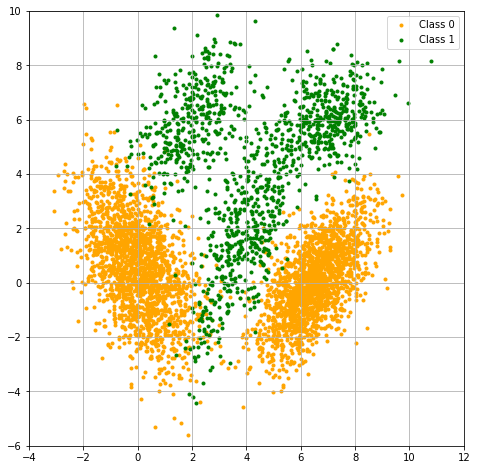

In [15]:
# Defining mixture distributions
dists = [
    [
        (0.5, multivariate_normal(mean=[0.0, 0.5], 
                                  cov=[[1.0, -0.8], 
                                       [-0.8, 3.0]])), 
        (0.5, multivariate_normal(mean=[6.5, 0.0], 
                                  cov=[[1.0, 0.9], 
                                       [0.9, 2.0]]))
    ], 
    [
        (0.3, multivariate_normal(mean=[2.0, 6.0], 
                                  cov=[[1.0, 0.5], 
                                       [0.5, 2.0]])), 
        (0.4, multivariate_normal(mean=[4.0, 2.0], 
                                  cov=[[1.0, 1.5], 
                                       [1.5, 5.0]])), 
        (0.3, multivariate_normal(mean=[7.0, 6.0], 
                                  cov=[[1.0, 0.3], 
                                       [0.3, 1.0]]))
    ]
]

# Class weights
weights = np.array([0.75, 0.25])

# ================================

def f_sample_from_mixture(mix_dist, n_samples=1, random_state=None):
    """
    Draws sample points from mixture of different distributions
    
    Parameters:
    ----------------
    mix_dist : list of tuples (w, d), where w is relative weight of distribution, d is scipy distribution
        object (which has rvs() method to draw sample). NOTE: w's must sum to 1!
    n_samples : int, number of samples to draw from mixed distribution
    random_state : int, NumPy pseudo-random generator seed
    
    Returns:
    ----------------
    NumPy array of shape (n_samples, x), where each row is a sample point. x is determined by dimensionality
        of distributions
    """
    
    # Setting preudo-random generator seed
    if not random_state is None:
        np.random.seed(random_state)
    
    # Drawing particular distribution component from which further to draw a point
    dkeys = np.random.choice(range(len(mix_dist)), size=n_samples, replace=True, 
                             p=[x[0] for x in mix_dist])
    
    res = []
    
    # Drawing samples from mixture components
    for (xkey, xdist) in enumerate(x[1] for x in mix_dist):
        res.append(xdist.rvs(size=(dkeys == xkey).sum()))
    
    # Shaking up samples
    return np.random.permutation(np.vstack(res))

n_samples = 5000

np.random.seed(SEED)

# Drawing number of objects of class 1 then generating features and class labels
n_class1 = np.random.binomial(n=n_samples, p=weights[1])
X1 = np.vstack([
    f_sample_from_mixture(dists[0], n_samples - n_class1, SEED), 
    f_sample_from_mixture(dists[1], n_class1, SEED)
])
y1 = np.hstack([np.zeros(n_samples - n_class1), np.ones(n_class1)])

# Shuffling samples (otherwise we have all 0's followed by all 1's)
X1, y1 = shuffle(X1, y1, random_state=SEED)

# Define plotting boundaries for later, and meshgrid for contour plots
xlim2 = (-4, 12)
ylim2 = (-6, 10)

xy_mesh2 = np.meshgrid(np.arange(xlim2[0], xlim2[1] + 0.01, 0.01), \
                       np.arange(ylim2[0], ylim2[1] + 0.01, 0.01))

# Reshaping meshgrid into shape that we can pass to classifier from sklearn
xy_mesh2_features = np.array([xy_mesh2[0].ravel(), xy_mesh2[1].ravel()]).T

# --------------------------------

# Plotting sampled points
plt.figure(figsize=(8, 8))
flag = y1 == 1

plt.scatter(X1[~flag, 0], X1[~flag, 1], label='Class 0', marker='.', color='orange')
plt.scatter(X1[flag, 0], X1[flag, 1], label='Class 1', marker='.', color='green')

plt.xlim(xlim2)
plt.ylim(ylim2)

plt.gca().set_aspect('equal')
plt.gca().grid(True)
plt.legend()

上記データセットを訓練データと正解データに分ける

In [16]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=1500, stratify=y1, random_state=SEED)

print('Test set size: {0}x{1}'.format(*X1_test.shape))
print('Training set size: {0}x{1}'.format(*X1_train.shape))

Test set size: 1500x2
Training set size: 3500x2


ケース1:多項式の特徴を持つロジスティック回帰
- 3次元の検索空間を作成します。
- 多項式の特徴の程度を1または2と仮定
- 正規化の対数定数Cとclass_weightパラメータを作成

In [17]:
hp_space_clf1 = {
    'poly': {
        'degree': 1 + hp.randint('degree', 1 + 1)
    }, 
    'clf': {
        'C': hp.loguniform('C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
        'class_weight': hp.choice('class_weight', [None, 'balanced'])
    }
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_clf1)

{'clf': {'C': 616.9971411760237, 'class_weight': None}, 'poly': {'degree': 2}}

In [18]:
# 探索スペースから生成される組み合わせでPipelineを用いてモデルをフィットさせていく
def f_clf1(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # Assembing pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(**hps['poly'], include_bias=False)), 
        # ロジスティック回帰のためscalerを行う
        ('scale', StandardScaler()), 
        # hpsで指定したCとclass_weightが設定される
        # Cやclass_weightのようにパラメータ名をそのまま変数名にしていると直接指定することが可能
        ('clf', LogisticRegression(**hps['clf'], solver='liblinear', max_iter=25000, random_state=SEED))
    ])
    
    return model

In [19]:
# 最小化する関数を定義する
def f_to_min1(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : target function value (negative mean cross-val ROC-AUC score)
    """
    # hps範囲のモデルを生成
    model = f_clf1(hps)
    # roc_aucで交差検証する,cvは検証方法？,n_jobsは使用するCPU数?
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, random_state=SEED), scoring='roc_auc', n_jobs=-1)
    
    # roc_aucは最大化することにより評価だ高いので出力には-をつける
    return -cv_res.mean()

In [20]:
# 最適化の履歴を記録
trials_clf1 = Trials()
# 最適化の開始
best_clf1 = fmin(partial(f_to_min1, X=X1_train, y=y1_train), 
                 hp_space_clf1, algo=tpe.suggest, max_evals=100, 
                 trials=trials_clf1, rstate=np.random.RandomState(SEED))

100%|██████████| 100/100 [00:04<00:00, 21.83it/s, best loss: -0.9942591394193329]


In [21]:
# 正解データで検証
# ベストスコアのパラメータを確認
print('Best parameters:')
print(space_eval(hp_space_clf1, best_clf1))
# 最良のパラメータでモデルを構築
clf1 = f_clf1(space_eval(hp_space_clf1, best_clf1)).fit(X1_train, y1_train)

# 最良のモデルを使用し、テストデータをで再現する
clf1_val_score = roc_auc_score(y1_test, clf1.predict_proba(X1_test)[:, 1])
print('Cross-val score: {0:.5f}; validation score: {1:.5f}'.format(-trials_clf1.best_trial['result']['loss'], clf1_val_score))


Best parameters:
{'clf': {'C': 2.077154576585185, 'class_weight': 'balanced'}, 'poly': {'degree': 2}}
Cross-val score: 0.99426; validation score: 0.99505


In [22]:
# 最適化履歴を詳細に抽出する関数
def f_wrap_space_eval(hp_space, trial):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    
    return space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})


# dict型を展開してくれる関数定義
def f_unpack_dict(dct):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

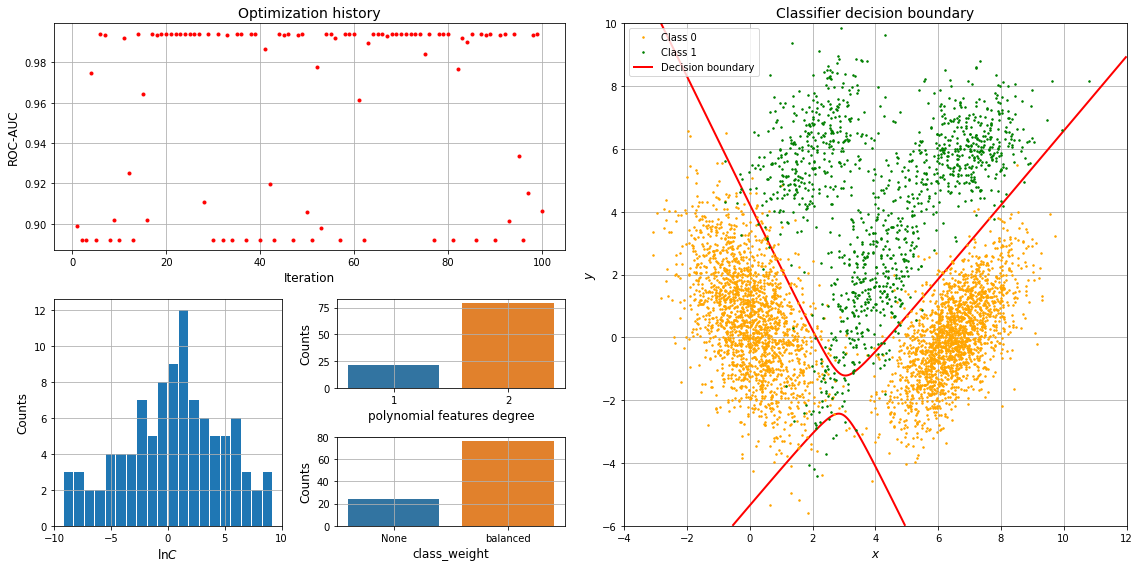

In [23]:
# プロット
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :2])
ax.plot(range(1, len(trials_clf1) + 1), [-x['result']['loss'] for x in trials_clf1], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf1, x)) for x in trials_clf1.trials]

ax = fig0.add_subplot(gs[2:, 0])
ax.hist(np.log([x['C'] for x in samples]), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('$\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2, 1])
sns.countplot(x=[x['degree'] for x in samples], ax=ax)

ax.set_xlabel('polynomial features degree', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[3, 1])
sns.countplot(x=[str(x['class_weight']) for x in samples], ax=ax)

ax.set_xlabel('class_weight', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ================================
# Plotting decision boundary

ax = fig0.add_subplot(gs[:, 2:])

# plt.contour is a bit tricky with legend labels, so it has to be constructed manually
legends = []

# Scattering sampled points and keeping their legend items
pts_class0, = ax.plot(X1[~flag, 0], X1[~flag, 1], label='Class 0', 
                      linewidth=0, marker='.', markersize=3, color='orange')
legends.append(pts_class0)
pts_class1, = ax.plot(X1[flag, 0], X1[flag, 1], label='Class 1', 
                      linewidth=0, marker='.', markersize=3, color='green')
legends.append(pts_class1)

# Decision boundary is build via plt.contour with single level line = 0.5, legend item added separately
cntr = ax.contour(xy_mesh2[0], xy_mesh2[1], 
                  clf1.predict_proba(xy_mesh2_features)[:, 1].\
                      reshape(xy_mesh2[0].shape[0], -1), 
                  levels = [0.5], colors='red', linewidths=2)
legends.append(cntr.legend_elements()[0][0])

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.set_title('Classifier decision boundary', fontsize=14)

ax.set_xlim(xlim2)
ax.set_ylim(ylim2)

ax.set_aspect('equal')
ax.grid(True)
ax.legend(legends, ['Class 0', 'Class 1', 'Decision boundary'])

# ================================

plt.tight_layout()

ケース2:ロジスティック回帰かサポートベクターマシンか選ぶ

In [24]:
hp_space_clf2 = {
    # type refers to classifier type: either logit or SVM
    'clf_type': hp.choice('clf_type', [
        {   # ロジスティック回帰のパラメータ範囲
            'type': 'logit', 
            'poly': {
                'degree': 1 + hp.randint('degree', 3 + 1), 
                'interaction_only': hp.choice('interaction_only', [False, True])}, 
            'clf': {
                # ロジスティック回帰SVMともにCとclass_weightがある。エラーが起こりやすいため名前つけに要注意
                'C': hp.loguniform('logit.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('logit.class_weight', [None, 'balanced'])}}, 
        {   # SVMのパラメータ範囲を指定
            'type': 'SVM', 
            'clf': {
                'C': hp.loguniform('svm.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('svm.class_weight', [None, 'balanced']), 
                'kernel': 'rbf', 
                'gamma': hp.choice('svm.gamma', ['auto', 'scale'])
            }
        }
    ])
}

# Draw random sample to see if hyperspace is correctly defined
ho_sample(hp_space_clf2)

{'clf_type': {'clf': {'C': 5836.421145025133, 'class_weight': None},
  'poly': {'degree': 4, 'interaction_only': False},
  'type': 'logit'}}

In [25]:
# 探索スペースから生成される組み合わせで条件分岐を用いて各モデルを分割し、パイプラインでfitさせていく
def f_clf2(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # logitの場合
    if hps['clf_type']['type'] == 'logit':
        model = Pipeline([
            ('poly', PolynomialFeatures(**hps['clf_type']['poly'], include_bias=False)), 
            ('scale', StandardScaler()), 
            ('clf', LogisticRegression(**hps['clf_type']['clf'], 
                                       solver='liblinear', max_iter=25000, random_state=SEED))
        ])
    # SVMの場合
    elif hps['clf_type']['type'] == 'SVM':
        model = Pipeline([
            ('scale', StandardScaler()), 
            # clfにはサブdictがあるためf_unpack_dictを適応させる必要がある
            ('clf', SVC(**f_unpack_dict(hps['clf_type']['clf']), probability=True, random_state=SEED))
        ])
    else:
        raise KeyError('Unknown classifier type hyperparameter value: {0}'.format(hps['clf_type']['type']))
    
    return model

In [26]:
# 最小化する関数を定義する
def f_to_min2(hps, X, y, ncv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : dict(
        'loss' : target function value (negative mean cross-validation ROC-AUC score)
        'cv_std' : cross-validation ROC-AUC score standard deviation
        'status' : status of function evaluation
    )
    """
    
    model = f_clf2(hps)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, random_state=SEED), scoring='roc_auc', n_jobs=-1)
    
    # 今回はdict型で結果を返すようにする
    return {
        'loss': -cv_res.mean(), 
        # 標準偏差を追加することで一貫性をもたせる
        'cv_std': cv_res.std(), 
        'status': STATUS_OK
    }

In [27]:
# 最適化の履歴を記録
trials_clf2 = Trials()
# 最適化
#　今回ハイパーパラメータの範囲が拡張した為、300回実行する
best_clf2 = fmin(partial(f_to_min2, X=X1_train, y=y1_train), 
                 hp_space_clf2, algo=tpe.suggest, max_evals=300, 
                 trials=trials_clf2, rstate=np.random.RandomState(SEED))

100%|██████████| 300/300 [02:29<00:00,  2.50it/s, best loss: -0.99714163494971]


In [28]:
# 正解データで検証
# ベストスコアのパラメータを確認
print('Best parameters:')
print(space_eval(hp_space_clf2, best_clf2))
# 最良のパラメータでモデルを構築
clf2 = f_clf2(space_eval(hp_space_clf2, best_clf2)).fit(X1_train, y1_train)

# 最良のモデルを使用し、テストデータをで再現する
clf2_val_score = roc_auc_score(y1_test, clf2.predict_proba(X1_test)[:, 1])
print('Cross-val score: {0:.5f} +/- {1:.5f}; validation score: {2:.5f}'.\
format(-trials_clf2.best_trial['result']['loss'], trials_clf2.best_trial['result']['cv_std'], 
             clf2_val_score))

Best parameters:
{'clf_type': {'clf': {'C': 19.787042248481985, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}, 'type': 'SVM'}}
Cross-val score: 0.99714 +/- 0.00137; validation score: 0.99651


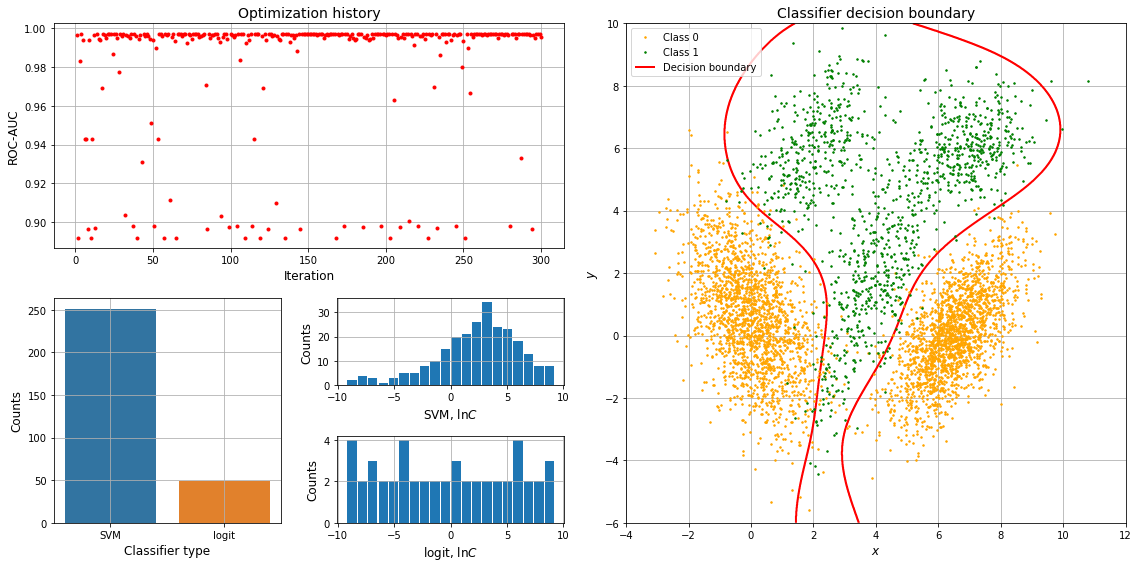

In [29]:
# プロット
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :2])
ax.plot(range(1, len(trials_clf2) + 1), [-x['result']['loss'] for x in trials_clf2], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf2, x)) for x in trials_clf2.trials]

ax = fig0.add_subplot(gs[2:, 0])
sns.countplot(x=[x['type'] for x in samples], ax=ax)

ax.set_xlabel('Classifier type', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2, 1])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'SVM']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('SVM, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[3, 1])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'logit']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('logit, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ================================
# Plotting decision boundary

ax = fig0.add_subplot(gs[:, 2:])

# plt.contour is a bit tricky with legend labels, so it has to be constructed manually
legends = []

# Scattering sampled points and keeping their legend items
pts_class0, = ax.plot(X1[~flag, 0], X1[~flag, 1], label='Class 0', 
                      linewidth=0, marker='.', markersize=3, color='orange')
legends.append(pts_class0)
pts_class1, = ax.plot(X1[flag, 0], X1[flag, 1], label='Class 1', 
                      linewidth=0, marker='.', markersize=3, color='green')
legends.append(pts_class1)

# Decision boundary is build via plt.contour with single level line = 0.5, legend item added separately
cntr = ax.contour(xy_mesh2[0], xy_mesh2[1], 
                  clf2.predict_proba(xy_mesh2_features)[:, 1].\
                      reshape(xy_mesh2[0].shape[0], -1), 
                  levels = [0.5], colors='red', linewidths=2)
legends.append(cntr.legend_elements()[0][0])

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.set_title('Classifier decision boundary', fontsize=14)

ax.set_xlim(xlim2)
ax.set_ylim(ylim2)

ax.set_aspect('equal')
ax.grid(True)
ax.legend(legends, ['Class 0', 'Class 1', 'Decision boundary'])

# ================================

plt.tight_layout()